<footer id="footer"></footer>

<h1 align='center'>Summarization</h1>
<p align="center"><img src="https://drive.google.com/uc?id=1P5VxMZ2GLNcTxcuPiB_b_Lb1Oy7OXx82"  border="0"></a></p>




# Text Summarization
 Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи суммаризации текста на примере генерации сжатых новостей.
Датасет: `gazeta.ru`


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.` <b> **Baseline** подготовлен [Deep learning school](https://www.dlschool.org/pro-track)

Загрузим датасет и необходимые библиотеки




<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


In [ ]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [ ]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa

     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 54 kB 3.7 MB/s 
     |████████████████████████████████| 8.2 MB 57.3 MB/s 


In [ ]:
!gdown 1JYHdHj5s9WCTakRwcMrI393iATEonc_h -O train_model.py

Downloading...
From: https://drive.google.com/uc?id=1JYHdHj5s9WCTakRwcMrI393iATEonc_h
To: /content/train_model.py
100% 5.09k/5.09k [00:00<00:00, 8.81MB/s]


In [ ]:
!pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 9.0 MB/s 


In [ ]:
import imp
import copy
import math
import json
import torch
import razdel
import random
import train_model
import matplotlib.pyplot as plt
from termcolor import colored
import warnings
import numpy as np
import torch.nn as nn
from rouge import Rouge
import torch.optim as optim
import youtokentome as yttm
from tqdm.notebook import tqdm
import torch.nn.functional as F
from train_model import train_with_logs
from nltk.translate.bleu_score import corpus_bleu
from sklearn.utils.class_weight import compute_class_weight
from train_model import punct_detokenize, postprocess
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

warnings.filterwarnings("ignore")

Здесь соберем основные функции, которые нам понадобятся

In [ ]:
# для визуализации модели

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)


# для чтения датасета
def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

# для подсчета скоров
def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref:", references[-1])
    print("Hyp:", predictions[-1])

    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

# BPE кодировка
def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

# рассчет весов классов
def get_class_weight(iterator, pad_idx=2, filter_pad=False):

  """для рассчета весов классов. С учетом паддинга и без"""
  
  print("Рассчет весов классов ...")
  cls = []
  for _ in range(1):
    for batch in tqdm(iterator):
        cls.extend(batch["outputs"].detach().cpu().numpy().tolist())
 

  cls = [item for sublist in cls for item in sublist]
  
  if filter_pad:
    cls = list(filter(lambda x: x != pad_idx, cls))

  class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls),
                                    y=cls)  
  if not filter_pad:
    class_weight[2] = 1e-6
  return torch.from_numpy(class_weight).float()


# обучение модели 
def train_it(model, use_class_weights, N_EPOCHS, CLIP, DEVICE, lr=1e-3, filter_pad=False):
    optimizer = optim.AdamW(model.parameters(), lr, weight_decay=0.001)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        weights = get_class_weight(train_iterator, filter_pad=filter_pad)
        criterion = nn.CrossEntropyLoss(weight=weights.to(DEVICE), ignore_index=-1)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=-1)
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Dataset

Посмотрим на то, как устроен датасет

In [ ]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [ ]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [ ]:
train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [ ]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем `oracle summary`, чтобы не пересчитывать их каждый раз

In [ ]:
def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    pbar = (tqdm(enumerate(records), total=nrows, leave=True))
    for i, record in pbar:
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


### Составление батчей

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class BatchIterator():
    def __init__(self, 
                 records, 
                 vocabulary, 
                 batch_size, 
                 bpe_processor, 
                 shuffle=True, 
                 lower=True, 
                 max_sentences=30, 
                 max_sentence_length=50, 
                 device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else \
                                 sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, 
                                                                     summary, 
                                                                     calc_score=calc_score, 
                                                                     lower=self.lower, 
                                                                     max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, 
                                         max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            tensor_outputs = 2 * torch.ones((self.batch_size, max_sentences), 
                                         dtype=torch.float32, device=self.device)
            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }

In [ ]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 64, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 64, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 64, bpe_processor, device=device)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


* В данной реализации в `outputs` в качестве padding используется индекс 2, чтобы не совпадать с классами, для этого мы будем использовать в качестфе функции потерь - `CrossEntropyLoss`, что позволит работать с логитами трех классов


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [ ]:
class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, 
                                 hidden_size, 
                                 n_layers, 
                                 dropout=dropout, 
                                 bidirectional=bidirectional, 
                                 batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
  
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SummaRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 use_bias=True,
                 token_embedding_dim=256,
                 sentence_encoder_hidden_size=512,
                 hidden_size=512,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.1):
        
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 3) # 3 класса 0, 1 и 2 для паддинга
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2, bias=False)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2, bias=False)
        self.tanh_layer = nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.use_bias = use_bias
        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty
        self.sentence_encoder_hidden_size = sentence_encoder_hidden_size

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        outputs = self.dropout_layer(outputs)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs) # 1-representation
            predictions = content

        if self.use_bias:
          bias_term = torch.zeros(3).uniform_(-0.1, 0.1).to(device) # на три класса
          predictions += bias_term

        # [batch_size, seq num]

        # # h^T * W * d
        if self.use_salience:
            # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)) # 2-representation
            predictions +=salience

        if self.use_novelty:

            # at every step add novelty to prediction of the sentence
            # 0) initialize summary_representation and novelty by zeros
            summary_representation = embedded_sentences.new_zeros((batch_size, self.sentence_encoder_hidden_size)).to(device)
            novelty = content.new_zeros((batch_size, sentences_count, 3)).to(device) # [batch_size, seq_num, num_classes]
            for sentence_num in range(sentences_count):
              # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
              sentence_num_state = outputs[:, sentence_num, :]
              novelty[:, sentence_num] = (-torch.bmm(sentence_num_state.unsqueeze(1), 
                                                    self.novelty_linear_layer(self.tanh_layer(summary_representation))
                                                    .unsqueeze(2))
                                                    .squeeze(2)
              )
              # 3) add novelty to predictions
              predictions[:, sentence_num] += novelty[:, sentence_num]
              # 4) calculcate probability for current sentence
              probability = self.sigmoid(predictions[:, sentence_num]) # была Softmax ... попробовал так
                                                                       # иначе логиты всегда меньше 0 выходили и работал только top_k
              probability = torch.max(probability[:, :2], 1)[0]
              # 5) add sentence_num_state with the weight which is equal to probability to summary_representation
              summary_representation += torch.mv(sentence_num_state.transpose(0, 1), probability)
        return predictions.permute(0, 2, 1) # развернуть для кроссэнтропии. Для каждого класса 3 логита

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


### Обучение и инференс без использования весов классов

#### Training

In [ ]:
vocab_size = len(vocabulary)
model_001 = SummaRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model_001.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 9132035


In [ ]:
model_structure(model_001)

sentence_encoder:
                  embedding_layer
                  rnn_layer
                  dropout_layer
rnn_layer
dropout_layer
content_linear_layer
document_linear_layer
salience_linear_layer
novelty_linear_layer
tanh_layer
softmax
sigmoid


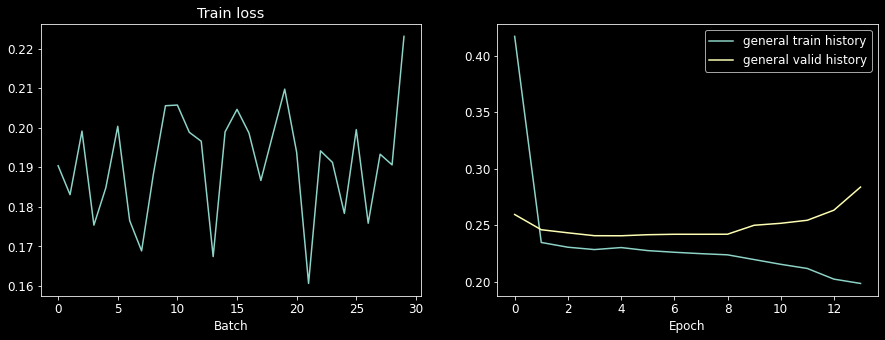

print train
Epoch: 15 | Time: 0m 22s
	Train Loss: 0.190 | Train PPL:   1.209
	 Val. Loss: 0.277 |  Val. PPL:   1.319


In [ ]:
imp.reload(train_model)

N_EPOCHS = 15
CLIP = .75
plt.style.use('dark_background')

train_it(model_001, False, N_EPOCHS, CLIP, device)

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


#### Inference

Сначала посмотрим скоры для топ-3 отбора, затем ддля логитов больше нуля

In [ ]:
def inference_summarunner(tagger, iterator, top_k=3):

    references = []
    predictions = []

    tagger.eval()
    for batch in iterator:

        logits = tagger(batch['inputs'])
        max = torch.max(logits, -1)[0]
        sum_in = torch.argsort(max, dim=1)[:, -top_k:]
        for i in range(len(batch['outputs'])):
            summary = batch['records'][i]['summary'].lower()
            pred_summary = ' '.join([batch['records'][i]['sentences'][ind.detach().cpu().item()] \
                                     for ind in sum_in.sort(dim=1)[0][i]])

            summary, pred_summary = postprocess(summary, pred_summary)
            references.append(summary)
            predictions.append(pred_summary)

    calc_scores(references, predictions)

model_001.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_001, test_iterator, 3)

Count: 512
Ref: российский миллиардер олег дерипаска был лишен гражданства кипра властями страны , передают местные сми . кроме того , кипрских паспортов лишены его сын и дочь . гражданства лишились и двое российских банкиров , разыскиваемых по обвинению в мошенничестве – александр бондаренко и владимир столяренко , а также их семьи . кипр начал проверять « золотые паспорта » , выданные в обмен на инвестиции , еще в начале ноября .
Hyp: власти кипра опубликовали список людей , лишенных гражданства страны по итогам проверки « золотых паспортов » , фактически купленных у правительства островного государства . как сообщает газета politis , кипрского гражданства в числе прочих лишились трое российских бизнесменов и их семьи . паспорт кипра аннулировали у миллиардера олега дерипаски , его сына и дочери , а также банкиров александра бондаренко и владимира столяренко .
BLEU:  0.44466339944984457
ROUGE:  {'rouge-1': {'f': 0.3062730368135899, 'p': 0.292675168417144, 'r': 0.34054733697305695}, '

In [ ]:
def inference_summarunner_logits(tagger, iterator):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    references = []
    predictions = []
    tagger.eval()
    for batch in iterator:
        logits = tagger(batch['inputs'])
        records = batch["records"]
        target = batch['outputs']
        logs = torch.max(logits, 1)[0]
        for record, log, trg in zip(records, logs, target):

            log = log[trg!=2] # отфильтровать padding
            sentences = record["sentences"]
            predicted_summary = []
            for i, logit in enumerate(log):
                if logit > 0.0:
                    
                    predicted_summary.append(sentences[i])

            if not predicted_summary:
                predicted_summary.append(sentences[torch.unique(torch.max(log, dim=0)[1]).item()])
            predicted_summary = " ".join(predicted_summary)
            references.append(record["summary"].lower())
            predictions.append(predicted_summary)

    calc_scores(references, predictions)

inference_summarunner_logits(model_001, test_iterator)

Count: 512
Ref: перед важным заседанием в тульском суде из зооуголка сбежал кот, который ранее стал орудием преступления. как выяснили следователи, в 2018 году злоумышленник использовал животное, чтобы доставлять наркотики в колонию. запрещенные вещество он клал в потайной карман ошейника кота — тем не менее при первой же попытке доставки сотрудники фсин заметили странную посылку и задержали мужчину.
Hyp: в туле перед заседанием суда сбежал важный вещдок — кот, с помощью которого заключенным в колонию передавались наркотики.
BLEU:  0.19801350086228844
ROUGE:  {'rouge-1': {'f': 0.23672859219412046, 'p': 0.38808460958887575, 'r': 0.18017284326851823}, 'rouge-2': {'f': 0.11290653638448299, 'p': 0.1939701275285045, 'r': 0.08497989674066837}, 'rouge-l': {'f': 0.17391682581496065, 'p': 0.34779469483601533, 'r': 0.16086373288960557}}


<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___


### Обучение и инференс с использованием весов классов

Обучим теперь, передавая веса в `CrossEntropyLoss` для наших классов - для паддинга будет передавать наименьший вес, и игнорировать в рассчетах. Также уменьшим размер записей `orcale_summary` до `256` для ускорения обучения и инференса

#### Training

In [ ]:
imp.reload(train_model)

vocab_size = len(vocabulary)
model_002 = SummaRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model_002.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

model_structure(model_002)

Trainable params: 9132035
sentence_encoder:
                  embedding_layer
                  rnn_layer
                  dropout_layer
rnn_layer
dropout_layer
content_linear_layer
document_linear_layer
salience_linear_layer
novelty_linear_layer
tanh_layer
softmax
sigmoid


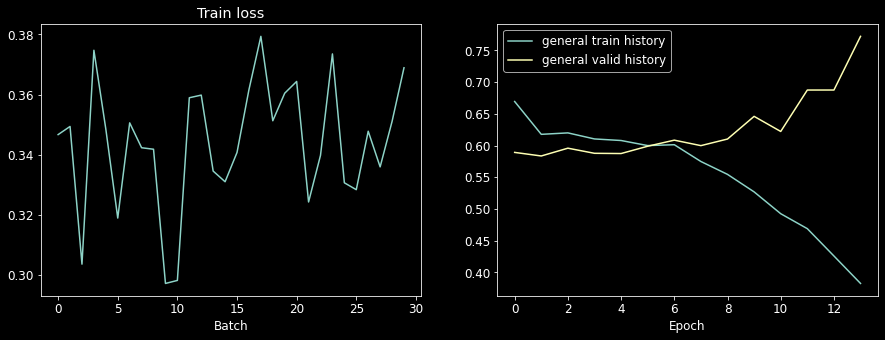

print train
Epoch: 15 | Time: 0m 21s
	Train Loss: 0.345 | Train PPL:   1.412
	 Val. Loss: 0.834 |  Val. PPL:   2.303


In [ ]:
N_EPOCHS = 15
CLIP = .75
plt.style.use('dark_background')
train_it(model_002, True, N_EPOCHS, CLIP, device, filter_pad=False)

#### Inference

In [ ]:
model_002.load_state_dict(torch.load('best-val-model.pt'))
inference_summarunner(model_002, test_iterator, 3)

Count: 256
Ref: международный суд оон отклонил возражения россии по иску украины , в котором киев обвиняет москву в финансировании терроризма , а также в культурном уничтожении и расовой дискриминации крымских татар и украинцев в крыму . в мид россии обращение украины в суд оон назвали « недобросовестным » , а в совете федерации указали , что претензии киева являются политическими .
Hyp: международный суд оон отклонил возражение россии , касающееся рассмотрения иска украины , которая обвиняет москву в финансировании терроризма . российская сторона указывала в заявлении , что суд оон не имеет юрисдикции для вынесения решений по таким делам . в итоге суд большинством голосов — 13 против трех — отказал россии в ее претензии .
BLEU:  0.4483358093852308
ROUGE:  {'rouge-1': {'f': 0.31733181247536885, 'p': 0.3031341514395033, 'r': 0.353196756345429}, 'rouge-2': {'f': 0.1427732219026844, 'p': 0.13475932187114892, 'r': 0.16339726182715164}, 'rouge-l': {'f': 0.2715462303275748, 'p': 0.2739258120

In [ ]:
inference_summarunner_logits(model_002, test_iterator)

Count: 256
Ref: с 1 января 2020 года whatsapp прекращает поддержку смартфонов с устаревшими версиями android и ios, а также всех гаджетов на базе windows phone. администрация мессенджера заявила, что будет заниматься поддержкой только тех ос, которые являются широко распространенными среди пользователей, постепенно отключая несовременные устройства от своей сети.
Hyp: начиная с 2020 года, мессенджер whatsapp перестанет работать у миллионов пользователей по всему миру, сообщает daily mail.
BLEU:  0.20397873375836117
ROUGE:  {'rouge-1': {'f': 0.24923742673588392, 'p': 0.4077675133660519, 'r': 0.1896603589183097}, 'rouge-2': {'f': 0.12242856615345309, 'p': 0.20930498200298375, 'r': 0.09247819223335302}, 'rouge-l': {'f': 0.1854575364054075, 'p': 0.3707542725062542, 'r': 0.1714586476775045}}


## Вывод:

Мы рассмотрели базовую архитектуру нейронных сетей для решения задач суммаризации текста на примере датасета `gazeta.ru`.


В результате проведенной работы, мы реализовали архитектуру `SummaRNN` - `Summarunner` с `novelty`. Позиции предложений не учитывались. также добавили `bias` в архитектуру и в качестве улучшения - для паддинга был выбран индекс `2`, что позволило отделить его от классов - `0` и `1`, характеризующих признак принадлежности предложения к итоговой суммаризации текста - это позволило применять в качестве функции потерь `CrossEntropyLoss` и использовать веса при вычислении. Значительного прироста данное решение нам не дало. 

В обоих вариантах обучения - с весами и без - мы получили `BLEU` примерно равный `0.45`, `rouge-1` - 0.32, `rouge-2` - 0.14 - при инференсе с применением метода `top_k`. При инференсе с применением метода по классификации логитов и отнесению их к классу `1` или `0` (логит больше нуля - `1` (при применении сигмоиды мы бы получали аналогичный рузельтат)) - мы получили меньшие значения:


для `BLEU` - `0.20`, `rouge-1` - `0.25`, `rouge-2` - `0.12`. В основном, мы получали 1-2 логита, которые характеризовали бы класс `1` (то есть были бы больше 0), соответственно - `summary` получали меньше, но стоит отметить, что неплохого качества


Таким образом, в данном исполнении лучше использовать метод `top_k`, что позволит максимищировать `Bleu`

<div style="float:left;margin:0 10px 10px 0" markdown="1">
    <a href="#footer"><img src='https://img.shields.io/badge/К содержанию-&#x21A9-blue'></a>
</div>

___
